### Categorical predictions

This notebook fits machine learning models to predict which students drop out of college.

In [332]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
import xgboost as xgb

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from ucimlrepo import fetch_ucirepo 

#### Read in, explore, and prepare the data

Get a sense for the data and prepare them for analyses.

In [333]:
# Dataset for student outcomes
# Open, publicly available
# Read more here:
# https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

# Fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 
  
# Data (as pandas dataframes) 
X = predict_students_dropout_and_academic_success.data.features 
y = predict_students_dropout_and_academic_success.data.targets 
  
# Metadata; commenting out because it's a lot!
# This code calling up .metadata is specific to this dataframe,
# would not work in most pandas dataframes
# print(predict_students_dropout_and_academic_success.metadata) 
  
# Variable information
# NOTE: This code works with this dataframe, but typically when
# working in Pandas, one would pull up information on the 
# columns/variables using data_frame_name.info()
print(predict_students_dropout_and_academic_success.variables) 

                                              name     role         type  \
0                                   Marital Status  Feature      Integer   
1                                 Application mode  Feature      Integer   
2                                Application order  Feature      Integer   
3                                           Course  Feature      Integer   
4                       Daytime/evening attendance  Feature      Integer   
5                           Previous qualification  Feature      Integer   
6                   Previous qualification (grade)  Feature   Continuous   
7                                      Nacionality  Feature      Integer   
8                           Mother's qualification  Feature      Integer   
9                           Father's qualification  Feature      Integer   
10                             Mother's occupation  Feature      Integer   
11                             Father's occupation  Feature      Integer   
12          

In [334]:
# Some integer features should be treated as categorical.
# Let's get some descriptive statistics on some of the
# features to better understand why they might be categories.
X[[
    "Application mode", 
    "Mother's qualification",
    "Father's qualification",
    "Nacionality",
    "Marital Status",
    ]].describe()
# Looking at Marital Status, we see a maximum of 6, so this is not a binary
# 0/1 feature. Instead it's a categorical feature that we need to set as 
# a category in the data.

,Application mode,Mother's qualification,Father's qualification,Nacionality,Marital Status
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,18.669078,19.561935,22.275316,1.873192,1.178571
std,17.484682,15.603186,15.343108,6.914514,0.605747
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,3.000000,1.000000,1.000000
50%,17.000000,19.000000,19.000000,1.000000,1.000000
75%,39.000000,37.000000,37.000000,1.000000,1.000000
max,57.000000,44.000000,44.000000,109.000000,6.000000


In [335]:
# For simplicity, let's drop most of the categorical features
features_to_drop = [
    "Application mode", 
    "Mother's qualification",
    "Father's qualification",
    "Nacionality",
    "Mother's occupation",
    "Father's occupation",
    "Previous qualification",
    "Course",
]
X = X.drop(columns=features_to_drop)


In [336]:
# We will transform the categorical feature Marital Status into a series of
# binary columns for each category but one
# This method drops one of the categories to avoid redudancy with the
# columns for the other categories
X = pd.get_dummies(X, columns=['Marital Status'], drop_first=True)

In [363]:
# Let's look at our simplified data
# Notice the columns for Martial Status
# (with value of 1 missing, that's the reference
# category)
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 32 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Application order                               4424 non-null   int64  
 1   Daytime/evening attendance                      4424 non-null   int64  
 2   Previous qualification (grade)                  4424 non-null   float64
 3   Admission grade                                 4424 non-null   float64
 4   Displaced                                       4424 non-null   int64  
 5   Educational special needs                       4424 non-null   int64  
 6   Debtor                                          4424 non-null   int64  
 7   Tuition fees up to date                         4424 non-null   int64  
 8   Gender                                          4424 non-null   int64  
 9   Scholarship holder                       

In [338]:
# Have 3 categories for the target, but for this demonstration, 
# want just 2 for simplicity
# Recoding Target into 2 labeled and 2 numeric categories
# For numeric categories, 1 = 'Late grad or drop-out'
y_recode = y.copy()
y_recode['TargetLabel'] = np.where(y_recode['Target'] == 'Graduate', 'On-time grad', 'Late grad or drop-out')
y_recode['TargetNumeric'] = np.where(y_recode['Target'] == 'Graduate', 0, 1)

[Text(0.5, 1.0, 'Counts for original 3 categories')]

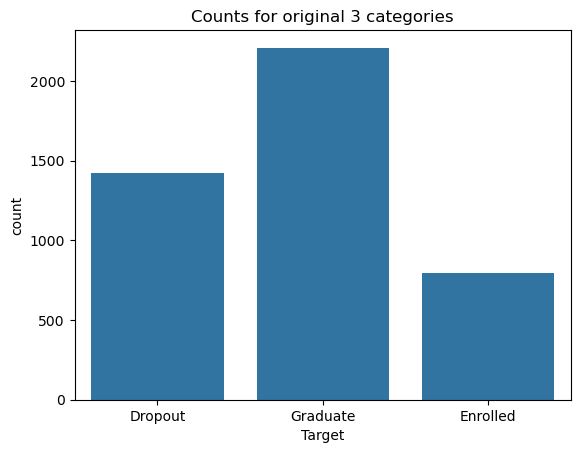

In [382]:
# Let's look at the original categories
sns.countplot(data=y, x='Target').set(title="Counts for original 3 categories")

[Text(0.5, 1.0, 'Counts for binary outcome')]

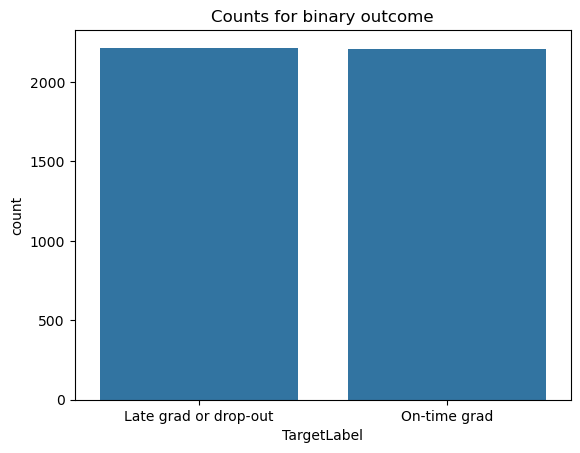

In [384]:
# And now let's look at our binary categories
sns.countplot(data=y_recode, x='TargetLabel').set(title="Counts for binary outcome")

Things to note from the above:
- When we have three categories, they are quite imbalanced.
- With two categories, the balance is amazing!

We will continue with two categories, but I've left code commented out that would allow you to run the models on all three categories. Note that different approaches have relative benefits depending on the nature of your data.

You can read more later here: https://medium.com/@hassaanidrees7/gradient-boosting-vs-random-forest-which-ensemble-method-should-you-use-9f2ee294d9c6

In [341]:
# Set aside 20% of the data as final testing dataset
# NOTE: The commented out part below is in case you want
# to build models predicting all 3 categories if you
# have extra time or want to do more after the presentation
X_modeling, X_test, y_modeling, y_test = train_test_split(
    X, y_recode['TargetNumeric'], test_size=0.20, random_state=55)
# X_modeling, X_test, y_modeling, y_test = train_test_split(
#     X, np.array(y), test_size=0.20, random_state=55)

In [342]:
# Get training and validation data
X_train, X_validate, y_train, y_validate = train_test_split(
    X_modeling, y_modeling, test_size=0.20, random_state=55)

#### Fit the random forest and gradient boost models

The following cells fit the models with default hyperparameters(not hyperparameters we choose). We only set the random_state for reproducibility. Hyperparameter tuning comes later!

- For future reference, you can read up on all of the hyperparamters and their defaults for GradientBoostingClassifier here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
- And here is where you can read up on all of the hyperparameters and their defaults for RandomForestClassfier, for future reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


In [356]:
# Fit a random forest classifier
rand_for = RandomForestClassifier(random_state=55)
rand_for.fit(X_train, y_train)

# Get predictions
rand_for_preds = rand_for.predict(X_validate)

# Print f1 score, classification report
# print('Rand forest f1 score: ', f1_score(rand_for_preds, y_validate, average='macro'))
print('Rand forest f1 score: ', round(f1_score(rand_for_preds, y_validate), 4))
print('Rand forest classification_report: \n', classification_report(rand_for_preds, y_validate))

# This "extra" step is just to make the code work whether or not
# people run some "optional" code below that I have commented out
best_model_rand_for = rand_for

Rand forest f1 score:  0.8539
Rand forest classification_report: 
               precision    recall  f1-score   support

           0       0.91      0.81      0.86       377
           1       0.80      0.91      0.85       331

    accuracy                           0.85       708
   macro avg       0.86      0.86      0.85       708
weighted avg       0.86      0.85      0.85       708



In [344]:
# Fit a gradient boosting classifier
grad_boost = GradientBoostingClassifier(random_state=55)
grad_boost.fit(X_train, y_train)

# Get predictions
grad_boost_preds = grad_boost.predict(X_validate)

# Print f1 score, classification report
# NOTE: The commented out part below is in case you want
# to build models predicting all 3 categories if you
# have extra time or want to do more after the presentation
# print('Grad boost f1 score: ', round(f1_score(grad_boost_preds, y_validate, average='macro'), 4))
print('Grad boost f1 score: ', round(f1_score(grad_boost_preds, y_validate), 4))
print('Grad boost classification report: \n', classification_report(grad_boost_preds, y_validate))

Grad boost f1 score:  0.836
Grad boost classification report: 
               precision    recall  f1-score   support

           0       0.89      0.79      0.84       376
           1       0.79      0.89      0.84       332

    accuracy                           0.84       708
   macro avg       0.84      0.84      0.84       708
weighted avg       0.84      0.84      0.84       708



In [346]:
# Hyperparameter tuning for grad boost
# Code adapted from this source:
# https://www.geeksforgeeks.org/how-to-tune-hyperparameters-in-gradient-boosting-algorithm/

# If you have extra time, you could play around with changing
# the parts with comments and see if you can do even better!

# Define the parameter grid for GridSearchCV
param_grid_grad_boost = {
    'n_estimators': [50, 100, 200], # Could try different and/or additional numbers here
    'learning_rate': [0.05, 0.1, 0.2, 0.3], # And here
    'max_depth': [2, 3, 4], # And here
}

# Initialize GridSearchCV
# NOTE: The commented out part below is in case you want
# to build models predicting all 3 categories if you
# have extra time or want to do more after the presentation
# grid_search_grad_boost = GridSearchCV(estimator=grad_boost, param_grid=param_grid_grad_boost, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search_grad_boost = GridSearchCV(estimator=grad_boost, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit the model to the training data using GridSearchCV
grid_search_grad_boost.fit(X_train, y_train)

# Get the best parameters and best model
best_params_grad_boost = grid_search_grad_boost.best_params_
best_model_grad_boost = grid_search_grad_boost.best_estimator_

# Make predictions on the test set using the best model
# The default for GridSearchCV is to update the model grad_boost
# to have the tuned hyperparameters, so the following will
# give predictions from the tuned model now
y_pred_best_grad_boost = best_model_grad_boost.predict(X_validate)

# Evaluate the best model
# NOTE: The commented out part below is in case you want
# to build models predicting all 3 categories if you
# have extra time or want to do more after the presentation
# f1_best_grad_boost = f1_score(y_validate, y_pred_best_grad_boost, average='macro')
f1_best_grad_boost = f1_score(y_validate, y_pred_best_grad_boost)
class_report_best_grad_boost = classification_report(y_validate, y_pred_best_grad_boost)

# Print the results
print("Grad boost best parameters: ", best_params_grad_boost)
print(f"Grad boost best model f1 score:  {round(f1_best_grad_boost, 4)}")
print(f"Grad boost best model classification report: \n{class_report_best_grad_boost}")

Grad boost best parameters:  {'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 100}
Grad boost best model f1 score:  0.8575
Grad boost best model classification report: 
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       334
           1       0.91      0.81      0.86       374

    accuracy                           0.86       708
   macro avg       0.86      0.86      0.86       708
weighted avg       0.86      0.86      0.86       708



In [348]:
# Commented out for time
# You can uncomment and run if you finish early or after the session
# To uncomment: select everything in this cell below here and use
# the keyboard shortcut Ctrl + c

# # Hyperparameter tuning for random forest classifier
# # Code adapted from this source (though note that I found some errors and other issues):
# # https://www.geeksforgeeks.org/random-forest-hyperparameter-tuning-in-python/

# # Define the parameter grid for GridSearchCV
# param_grid_rand_for = {
#     'n_estimators': [50, 100, 200],
#     'max_features': ['sqrt', 'log2'],
#     'max_depth': [None, 2, 3],
# }

# # Initialize GridSearchCV for random forest classifier
# # grid_search_rand_for = GridSearchCV(estimator=rand_for, param_grid=param_grid_rand_for, cv=5, scoring='f1_macro', n_jobs=-1)
# grid_search_rand_for = GridSearchCV(estimator=rand_for, param_grid=param_grid_rand_for, cv=5, scoring='f1', n_jobs=-1)

# # Fit the model to the training data using GridSearchCV
# grid_search_rand_for.fit(X_train, y_train)

# # Get the best parameters and best model
# best_params_rand_for = grid_search_rand_for.best_params_
# best_model_rand_for = grid_search_rand_for.best_estimator_

# # Make predictions on the test set using the best model
# # The default for GridSearchCV is to update the model grad_boost
# # to have the tuned hyperparameters, so the following will
# # give predictions from the tuned model now
# y_pred_best_rand_for = best_model_rand_for.predict(X_validate)

# # Evaluate the best model
# # NOTE: The commented out part below is in case you want
# # to build models predicting all 3 categories if you
# # have extra time or want to do more after the presentation
# # f1_best_rand_for = f1_score(y_validate, y_pred_best_grad_boost, average='macro')
# f1_best_rand_for = f1_score(y_validate, y_pred_best_rand_for)
# class_report_best_rand_for = classification_report(y_validate, y_pred_best_rand_for)

# # Print the results
# print("Random forest best parameters: ", best_params_rand_for)
# print(f"Rand forest best model f1 score:  {round(f1_best_rand_for, 4)}")
# print(f"Rand forest best model classification report: \n{class_report_best_rand_for}")

Random forest best parameters:  {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
Rand forest best model f1 score:  0.8539
Rand forest best model classification report: 
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       334
           1       0.91      0.80      0.85       374

    accuracy                           0.85       708
   macro avg       0.86      0.86      0.85       708
weighted avg       0.86      0.85      0.85       708



#### Discuss what you see!

What do you see when you compare the default model to the tuned model?
- Did hyperparamter tuning improve your f1 score?
- If so, by how much?
- What are your reactions to these results?

#### Feature importances

A critique of machine learning is that it can lack transperency. We can add some transparency but pulling up feature importances. These are _not_ the same as parameters you might see in a logistic regression model. Rather, they are values that tell you which features (or predictors or independent variables) were most influential in the predicitons from the model.

In [349]:
# Boosting model feature importances
grad_boost_importances = best_model_grad_boost.feature_importances_
grad_boost_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': grad_boost_importances
}).sort_values(
    axis=0,
    by='Importance',
    ascending=False
)

[Text(0.5, 1.0, 'Feature importances for grad boost')]

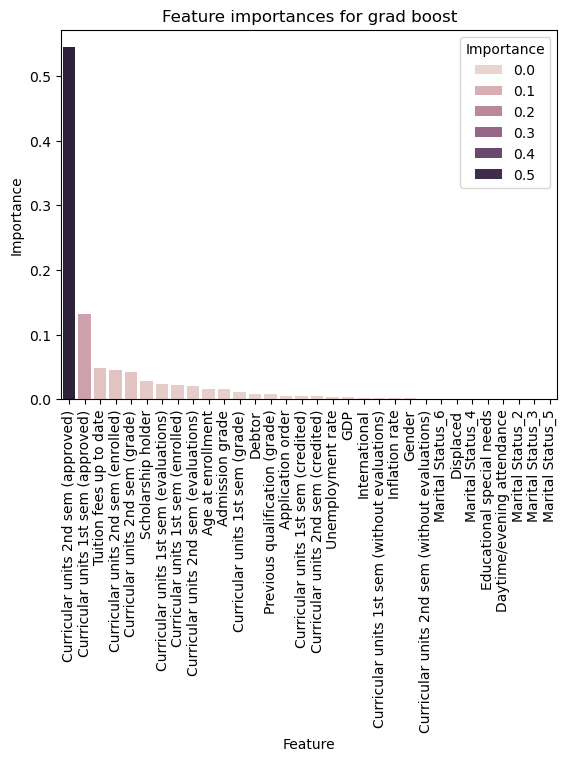

In [377]:
# Creating the data viz
g_boost = sns.barplot(
    grad_boost_importances_df,
    x='Feature',
    y='Importance',
    hue='Importance'
)
# Rotating the labels for readability
g_boost.tick_params(axis='x', rotation=90)
g_boost.set(title="Feature importances for grad boost")


In [380]:
# Commented out for time, you can uncomment
# Random forest model feature importances
# rand_for_importances = best_model_rand_for.feature_importances_
# rand_for_importances_df = pd.DataFrame({
#     'Feature': X_train.columns,
#     'Importance': rand_for_importances
# }).sort_values(
#     axis=0,
#     by='Importance',
#     ascending=False
# )

In [381]:
# Commented out for time, you can uncomment
# Creating the data viz, then rotating the labels and setting a title
# g_rand_for = sns.barplot(
#     rand_for_importances_df,
#     x='Feature',
#     y='Importance',
#     hue='Importance'
# )
# g_rand_for.tick_params(axis='x', rotation=90)
# g_rand_for.set(title="Feature importances for random forest")

#### Discuss feature importances

- What does the above tell you about the features that contributed the most information to predictions from the model?
- Anything that surprised you?
- Based on these importances, are there features you would leave out of future models for simplicity?

#### The final step!

Once you have done all you plan to do to improve your predictions with your model, you can see how it runs on the "hold out"  or "out of bag" data, the data we've never looked at before. This gives us a better sense of how we expect the model to perform in real time with data it has never "seen" before.

Below, we'll get predictions and then compute the relevant metrics for the unseen data as a final gauge of how well we expect our models to perform in the real world, both for the (untuned) random forest and for the tuned gradient boosting model.


In [360]:
# NOTE: Unless you uncommented the part that hyperparameter
# tunes the random forest, this is for the untuned model

# Random forest
# Getting predictions from hold out data first
y_pred_hold_out_rand_for = best_model_rand_for.predict(X_test)

# Evaluate the best model
f1_hold_out_rand_for = f1_score(y_test, y_pred_hold_out_rand_for)
class_report_hold_out_rand_for = classification_report(y_test, y_pred_hold_out_rand_for)

# Print the results
print(f"Rand forest f1 score from hold out data:  {round(f1_hold_out_rand_for, 4)}")
print(f"Rand forest best model classification report: \n{class_report_hold_out_rand_for}")

Rand forest f1 score from hold out data:  0.8492
Rand forest best model classification report: 
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       422
           1       0.88      0.82      0.85       463

    accuracy                           0.85       885
   macro avg       0.85      0.85      0.85       885
weighted avg       0.85      0.85      0.85       885



In [361]:
# Gradient boost
# Getting predictions from hold out data first
y_pred_hold_out_grad_boost = best_model_grad_boost.predict(X_test)

# Evaluate the best model
f1_hold_out_grad_boost = f1_score(y_test, y_pred_hold_out_grad_boost)
class_report_hold_out_grad_boost = classification_report(y_test, y_pred_hold_out_grad_boost)

# Print the results
print(f"Grad boost f1 score from hold out data:  {round(f1_hold_out_grad_boost, 4)}")
print(f"Grad boost best model classification report: \n{class_report_hold_out_grad_boost}")

Grad boost f1 score from hold out data:  0.8422
Grad boost best model classification report: 
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       422
           1       0.89      0.80      0.84       463

    accuracy                           0.84       885
   macro avg       0.85      0.84      0.84       885
weighted avg       0.85      0.84      0.84       885



#### Discuss the final predictions

- Which approach (random forest or gradient boosting) performed better on the unseen testing data?
- What are your reactions to this finding?

#### Additional things you can try on your own

1. Uncomment out the sections we "skipped" for random forest, including hyperparameter tuning and feature importances.
2. Uncommended out the parts that would allow you to run the models predicting all three original categories.

For anything extra you do, what do you see? What surprises you? What lessons might you take from these findings to guide you in future machine learning modeling?